# Import Tools

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F

from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric import torch as pyg_torch
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Torch device: {device}")
print(f"PyG using CUDA: {pyg_torch.cuda.is_available()}")

Torch device: cuda
PyG using CUDA: True


In [3]:
# Save processed data
expression_data_scaled=pd.read_csv("../Processed Datasets/processed_expression.csv")
methylation_scaled=pd.read_csv("../Processed Datasets/processed_methylation.csv")
copy_number_scaled=pd.read_csv("../Processed Datasets/processed_cnv.csv")
protein_scaled=pd.read_csv("../Processed Datasets/processed_protein.csv")
phenotype_data_cleaned=pd.read_csv("../Processed Datasets/processed_phenotype.csv")
subtype_mapping=pd.read_csv("../Processed Datasets/subtype_mapping_with_protein.csv")
subtype_labels = pd.read_csv("../Processed Datasets/subtype_labels.csv")
print("Expression:", expression_data_scaled.shape)
print("Methylation:", methylation_scaled.shape)
print("Copy Number:", copy_number_scaled.shape)
print("Protein:", protein_scaled.shape)
print("Phenotype:", phenotype_data_cleaned.shape)
print("Phenotype:", subtype_mapping.shape)

Expression: (60660, 247)
Methylation: (212382, 247)
Copy Number: (56756, 247)
Protein: (457, 211)
Phenotype: (210, 79)
Phenotype: (13, 2)


In [4]:
print(expression_data_scaled.iloc[:5, :5])  # First 5 rows/columns
print(methylation_scaled.iloc[:5, :5])
print(copy_number_scaled.iloc[:5, :5])
print(protein_scaled.iloc[:5, :5])
print(phenotype_data_cleaned.iloc[:5, :5])
print(subtype_mapping.head())


           Ensembl_ID  TCGA-DX-AB2O-01A  TCGA-IS-A3K7-01A  TCGA-DX-A7EQ-01A  \
0  ENSG00000000003.15         -1.152830         -0.219623         -0.884881   
1   ENSG00000000005.6          0.330547         -1.014041         -0.763520   
2  ENSG00000000419.13         -0.213944         -0.593653         -4.090048   
3  ENSG00000000457.14          0.822442         -1.529460         -2.880470   
4  ENSG00000000460.17          1.047877         -1.004992         -4.226427   

   TCGA-FX-A48G-01A  
0         -0.526559  
1          0.378398  
2         -3.689964  
3         -2.294075  
4         -3.340772  
  Composite Element REF  TCGA-DX-AB2O-01A  TCGA-IS-A3K7-01A  TCGA-DX-A7EQ-01A  \
0            cg00000165          1.499566         -0.235202         -1.133312   
1            cg00000292          0.303039          0.485554         -1.261731   
2            cg00000321         -1.374888         -0.928886         -0.113112   
3            cg00000363         -0.540672          0.649121         -

In [5]:
# Fix data indexing first - set the first column as index for each omics data
expression_data_scaled = expression_data_scaled.set_index(expression_data_scaled.columns[0])
methylation_scaled = methylation_scaled.set_index(methylation_scaled.columns[0])
copy_number_scaled = copy_number_scaled.set_index(copy_number_scaled.columns[0])
protein_scaled = protein_scaled.set_index(protein_scaled.columns[0])
phenotype_data_cleaned = phenotype_data_cleaned.set_index(phenotype_data_cleaned.columns[0])

print("Data shapes after setting index:")
print(f"  Expression: {expression_data_scaled.shape}")
print(f"  Methylation: {methylation_scaled.shape}")
print(f"  Copy number: {copy_number_scaled.shape}")
print(f"  Protein: {protein_scaled.shape}")
print(f"  Phenotype: {phenotype_data_cleaned.shape}")

# Sample matching
subtype_column = 'primary_diagnosis.diagnoses'

# Get sample sets from each omics type
samples_expression = set(expression_data_scaled.columns)
samples_methylation = set(methylation_scaled.columns)
samples_cnv = set(copy_number_scaled.columns)
samples_protein = set(protein_scaled.columns)
samples_clinical = set(phenotype_data_cleaned.index)

print("Sample overlap:")
print(f"Expression samples: {len(samples_expression)}")
print(f"Methylation samples: {len(samples_methylation)}")
print(f"CNV samples: {len(samples_cnv)}")
print(f"Protein samples: {len(samples_protein)}")
print(f"Clinical samples: {len(samples_clinical)}")

# Find common samples across all omics
common_samples = list(samples_expression.intersection(samples_methylation, samples_cnv, samples_protein, samples_clinical))
print(f"Common samples across all omics: {len(common_samples)}")

# Extract subtypes for the common samples
subtypes = phenotype_data_cleaned.loc[common_samples, subtype_column]

# Remove any samples with missing subtypes
subtypes_clean = subtypes.dropna()
final_samples = list(subtypes_clean.index)

print(f"Samples after removing missing subtypes: {len(final_samples)}")

# Encode subtypes as numeric labels
label_encoder = LabelEncoder()
subtype_encoded = label_encoder.fit_transform(subtypes_clean)

# Create mapping to encode subtype classes
subtype_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"\nSubtype encoding mapping:")
for subtype, encoded in subtype_mapping.items():
    print(f"  {encoded}: {subtype}")

# Convert to pandas Series
subtype_encoded = pd.Series(subtype_encoded, index=subtypes_clean.index, name='subtype_encoded')

# Filter out unwanted subtype labels for training
skip_labels = [2,5,4,6,7,8,9,10,11]
mask = ~subtype_encoded.isin(skip_labels)
subtype_encoded = subtype_encoded[mask]
final_samples_filtered = list(subtype_encoded.index)

print(f"\nEncoded subtype distribution (after skipping labels {skip_labels}):")
print(subtype_encoded.value_counts().sort_index())

# Filter all omics data to final common samples (after skipping labels)
expression_data_scaled = expression_data_scaled[final_samples_filtered]
methylation_scaled = methylation_scaled[final_samples_filtered]
copy_number_scaled = copy_number_scaled[final_samples_filtered]
protein_scaled = protein_scaled[final_samples_filtered]

common_samples = final_samples_filtered
print()
print(f"Final data shapes after phenotype preprocessing and label skipping:")
print(f"  Expression: {expression_data_scaled.shape}")
print(f"  Methylation: {methylation_scaled.shape}")
print(f"  Copy number: {copy_number_scaled.shape}")
print(f"  Protein: {protein_scaled.shape}")
print(f"  Phenotype: {phenotype_data_cleaned.shape}")
print(f"  Subtypes: {len(subtype_encoded)}")
print(f"  Common samples: {len(common_samples)}")

Data shapes after setting index:
  Expression: (60660, 246)
  Methylation: (212382, 246)
  Copy number: (56756, 246)
  Protein: (457, 210)
  Phenotype: (210, 78)
Sample overlap:
Expression samples: 246
Methylation samples: 246
CNV samples: 246
Protein samples: 210
Clinical samples: 210
Common samples across all omics: 210
Samples after removing missing subtypes: 210

Subtype encoding mapping:
  0: Dedifferentiated liposarcoma
  1: Fibromyxosarcoma
  2: Giant cell sarcoma
  3: Leiomyosarcoma, NOS
  4: Liposarcoma, well differentiated
  5: Malignant fibrous histiocytoma
  6: Malignant peripheral nerve sheath tumor
  7: Myxoid leiomyosarcoma
  8: Pleomorphic liposarcoma
  9: Synovial sarcoma, NOS
  10: Synovial sarcoma, biphasic
  11: Synovial sarcoma, spindle cell
  12: Undifferentiated sarcoma

Encoded subtype distribution (after skipping labels [2, 5, 4, 6, 7, 8, 9, 10, 11]):
subtype_encoded
0     49
1     20
3     76
12    32
Name: count, dtype: int64

Final data shapes after phenotyp

# Reduce Dimension

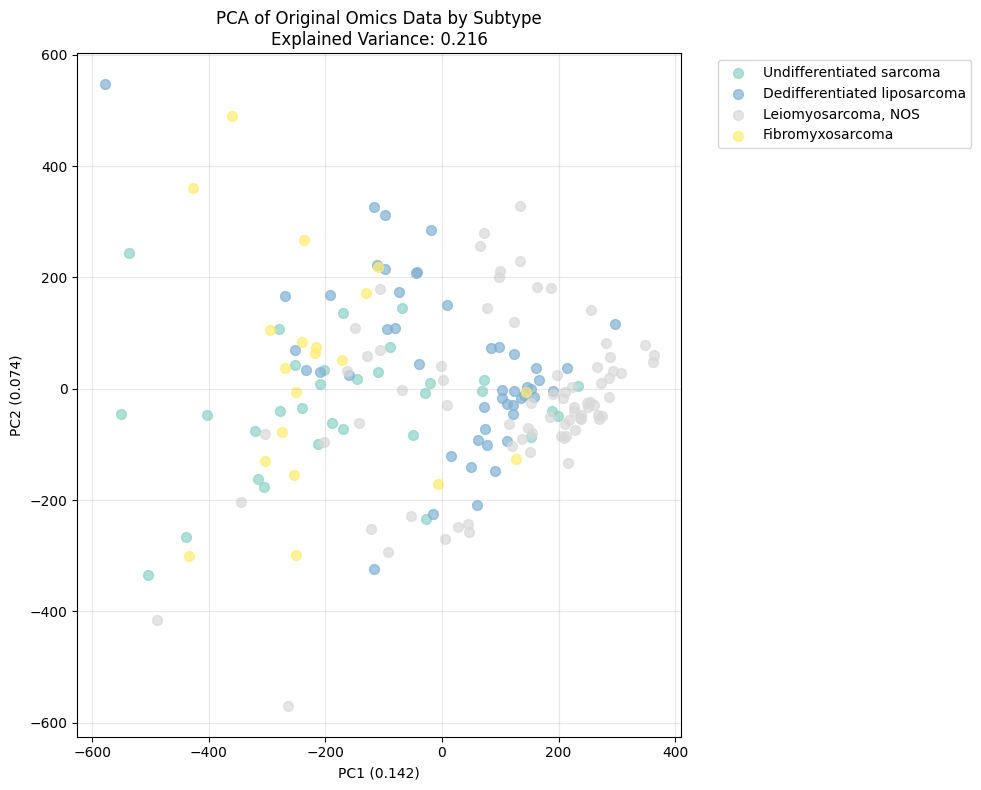

In [6]:
# PCA visualization of subtypes using original (raw) omics data
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Concatenate all omics data (features x samples), then transpose to (samples x features)
original_omics = [expression_data_scaled, methylation_scaled, copy_number_scaled, protein_scaled]
original_embeddings = pd.concat(original_omics, axis=0).T

# Apply PCA
pca = PCA(n_components=2, random_state=42)
original_2d = pca.fit_transform(original_embeddings.values)

# Prepare subtype labels for coloring
unique_subtypes = subtype_encoded.unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_subtypes)))
class_names = [list(subtype_mapping.keys())[list(subtype_mapping.values()).index(i)] for i in range(len(subtype_mapping))]

plt.figure(figsize=(10, 8))
for i, subtype in enumerate(unique_subtypes):
    mask = subtype_encoded == subtype
    plt.scatter(original_2d[mask, 0], original_2d[mask, 1],
                c=[colors[i]], label=class_names[subtype], alpha=0.7, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
plt.title(f'PCA of Original Omics Data by Subtype\nExplained Variance: {pca.explained_variance_ratio_.sum():.3f}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Autoencoder

In [7]:
# Simple autoencoder function without class structure
def create_autoencoder(input_dim, hidden_dim=128, latent_dim=64):
    """Create a simple autoencoder model"""
    encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, latent_dim),
        nn.ReLU(inplace=True)
    )
    
    decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, input_dim)
    )
    
    return encoder, decoder

def autoencoder_forward(encoder, decoder, x):
    """Forward pass through autoencoder"""
    latent = encoder(x)
    reconstructed = decoder(latent)
    return reconstructed, latent

def train_autoencoder(encoder, decoder, X, epochs=100, lr=0.001, batch_size=32, val_split=0.2):
    """Train autoencoder with reconstruction loss and validation tracking"""
    # Combine encoder and decoder for joint training
    class AutoencoderModel(nn.Module):
        def __init__(self, encoder, decoder):
            super().__init__()
            self.encoder = encoder
            self.decoder = decoder
        
        def forward(self, x):
            latent = self.encoder(x)
            reconstructed = self.decoder(latent)
            return reconstructed, latent
    
    model = AutoencoderModel(encoder, decoder)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Split data into train and validation
    n_samples = X.shape[0]
    n_val = int(n_samples * val_split)
    n_train = n_samples - n_val
    
    # Random split
    indices = torch.randperm(n_samples)
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]
    
    X_train = X[train_indices]
    X_val = X[val_indices]
    
    # Create data loaders
    train_dataset = TensorDataset(X_train)
    val_dataset = TensorDataset(X_val)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Track metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    def calculate_reconstruction_accuracy(original, reconstructed, threshold=0.1):
        """Calculate reconstruction accuracy based on relative error threshold"""
        relative_error = torch.abs(original - reconstructed) / (torch.abs(original) + 1e-8)
        accuracy = (relative_error < threshold).float().mean()
        return accuracy.item()
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_epoch_loss = 0.0
        train_epoch_acc = 0.0
        train_batches = 0
        
        for batch in train_dataloader:
            batch_x = batch[0]
            
            optimizer.zero_grad()
            reconstructed, _ = model(batch_x)
            loss = criterion(reconstructed, batch_x)
            loss.backward()
            optimizer.step()
            
            train_epoch_loss += loss.item()
            train_epoch_acc += calculate_reconstruction_accuracy(batch_x, reconstructed)
            train_batches += 1
        
        avg_train_loss = train_epoch_loss / train_batches
        avg_train_acc = train_epoch_acc / train_batches
        
        # Validation phase
        model.eval()
        val_epoch_loss = 0.0
        val_epoch_acc = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                batch_x = batch[0]
                reconstructed, _ = model(batch_x)
                loss = criterion(reconstructed, batch_x)
                
                val_epoch_loss += loss.item()
                val_epoch_acc += calculate_reconstruction_accuracy(batch_x, reconstructed)
                val_batches += 1
        
        avg_val_loss = val_epoch_loss / val_batches
        avg_val_acc = val_epoch_acc / val_batches
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(avg_train_acc)
        val_accs.append(avg_val_acc)
        
        if (epoch + 1) % 20 == 0:
            print(f"   Epoch [{epoch+1}/{epochs}]")
            print(f"      Train Loss: {avg_train_loss:.6f}, Train Acc: {avg_train_acc:.4f}")
            print(f"      Val Loss: {avg_val_loss:.6f}, Val Acc: {avg_val_acc:.4f}")
    
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    
    return model, metrics

In [8]:
# Initialize and train autoencoders for each omics type
omics_scaled = {
    'expr': expression_data_scaled,
    'meth': methylation_scaled,
    'cnv': copy_number_scaled,
    'prot': protein_scaled
}

# Store autoencoder components
encoders = {}
decoders = {}
latent_representations = {}
trained_models = {}
training_losses = {}
print("="*60)
print("TRAINING AUTOENCODERS FOR EACH OMICS TYPE")
print("="*60)

for name, df in omics_scaled.items():
    print(f"\n>> Processing {name.upper()} modality")
    print("-" * 40)
    
    # Prepare data (samples, features)
    X = torch.tensor(df.values.T, dtype=torch.float32, device=device)
    input_dim = X.shape[1]
    sample_ids = df.columns
    
    print(f"Data shape: {df.shape} -> After transpose: {X.shape}")
    print(f"Input dimension (features): {input_dim}")
    
    # Create autoencoder components
    encoder, decoder = create_autoencoder(
        input_dim=input_dim,
        hidden_dim=128,
        latent_dim=64
    )
    
    # Move to device
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    # Train autoencoder
    print(f"Training autoencoder for {name}...")
    trained_model, metrics = train_autoencoder(
        encoder, decoder, X, 
        epochs=100, lr=0.001, batch_size=32, val_split=0.2
    )
    
    # Store components
    encoders[name] = trained_model.encoder
    decoders[name] = trained_model.decoder
    trained_models[name] = trained_model
    training_losses[name] = metrics
    
    # Extract latent representation from trained model
    trained_model.eval()
    with torch.no_grad():
        _, latent = trained_model(X)
    
    # Store latent representation as DataFrame
    latent_representations[name] = pd.DataFrame(
        latent.cpu().numpy(),
        index=sample_ids,
        columns=[f"{name}_latent_{i}" for i in range(latent.shape[1])]
    )
    
    print(f"   Final Metrics:")
    print(f"      Train Loss: {metrics['train_losses'][-1]:.6f}, Train Acc: {metrics['train_accs'][-1]:.4f}")
    print(f"      Val Loss: {metrics['val_losses'][-1]:.6f}, Val Acc: {metrics['val_accs'][-1]:.4f}")
    print(f"   Latent representation shape: {latent_representations[name].shape}")

print("\n" + "="*60)
print("AUTOENCODER TRAINING COMPLETE!")
print("="*60)

# Display comprehensive training summary
print("\nCOMPREHENSIVE TRAINING SUMMARY:")
print("-" * 50)
print(f"{'Modality':<12} {'Train Loss':<12} {'Val Loss':<12} {'Train Acc':<12} {'Val Acc':<12}")
print("-" * 50)

for name, metrics in training_losses.items():
    train_loss = metrics['train_losses'][-1]
    val_loss = metrics['val_losses'][-1]
    train_acc = metrics['train_accs'][-1]
    val_acc = metrics['val_accs'][-1]
    
    print(f"{name.upper():<12} {train_loss:<12.6f} {val_loss:<12.6f} {train_acc:<12.4f} {val_acc:<12.4f}")

print("-" * 50)
print(f"\nAll autoencoders trained and ready for downstream tasks!")

# Display best/worst performing modalities
print(f"\nPERFORMANCE ANALYSIS:")
print("-" * 30)

# Find best validation accuracy
best_val_acc = 0
best_modality = ""
worst_val_acc = 1
worst_modality = ""

for name, metrics in training_losses.items():
    val_acc = metrics['val_accs'][-1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_modality = name
    if val_acc < worst_val_acc:
        worst_val_acc = val_acc
        worst_modality = name

print(f"Best Validation Accuracy: {best_modality.upper()} ({best_val_acc:.4f})")
print(f"Worst Validation Accuracy: {worst_modality.upper()} ({worst_val_acc:.4f})")

TRAINING AUTOENCODERS FOR EACH OMICS TYPE

>> Processing EXPR modality
----------------------------------------
Data shape: (60660, 177) -> After transpose: torch.Size([177, 60660])
Input dimension (features): 60660
Data shape: (60660, 177) -> After transpose: torch.Size([177, 60660])
Input dimension (features): 60660
Training autoencoder for expr...
Training autoencoder for expr...
   Epoch [20/100]
      Train Loss: 0.815611, Train Acc: 0.0258
      Val Loss: 0.783568, Val Acc: 0.0145
   Epoch [20/100]
      Train Loss: 0.815611, Train Acc: 0.0258
      Val Loss: 0.783568, Val Acc: 0.0145
   Epoch [40/100]
      Train Loss: 0.668212, Train Acc: 0.0483
      Val Loss: 0.772490, Val Acc: 0.0276
   Epoch [40/100]
      Train Loss: 0.668212, Train Acc: 0.0483
      Val Loss: 0.772490, Val Acc: 0.0276
   Epoch [60/100]
      Train Loss: 0.585598, Train Acc: 0.0707
      Val Loss: 0.770786, Val Acc: 0.0300
   Epoch [60/100]
      Train Loss: 0.585598, Train Acc: 0.0707
      Val Loss: 0.77

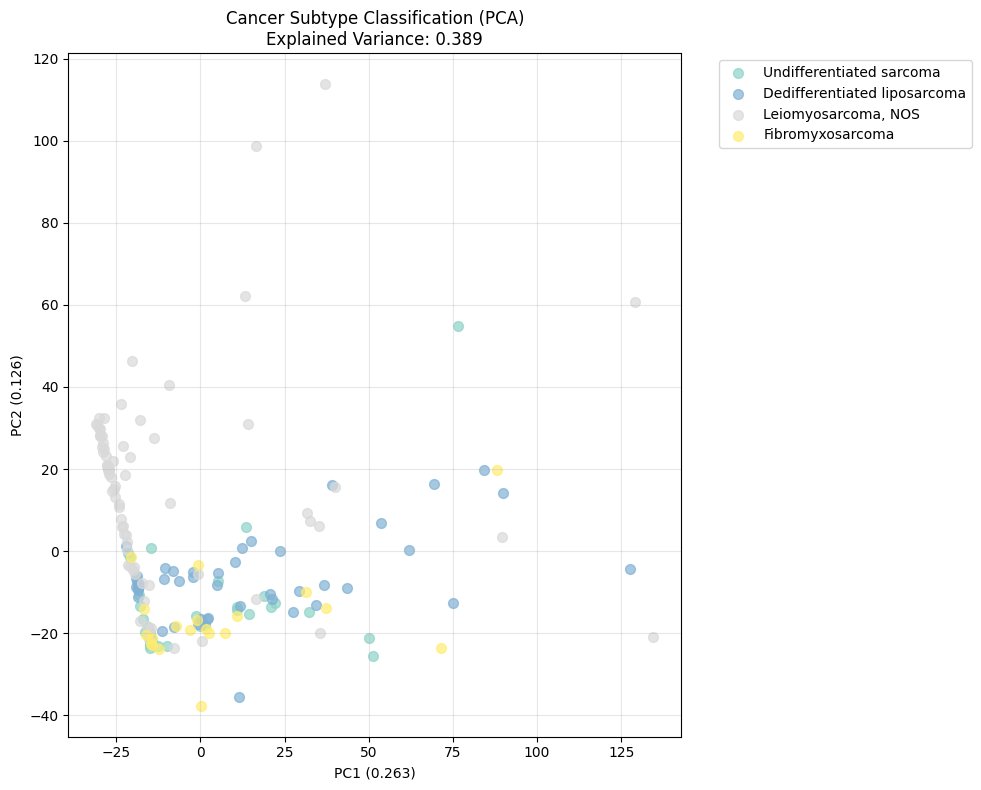

In [9]:
# Classification Visualization with PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Combine all latent representations
combined_latent = pd.concat(list(latent_representations.values()), axis=1)

# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
latent_2d = pca.fit_transform(combined_latent.values)

# Create the plot
plt.figure(figsize=(10, 8))

# Get unique subtypes and colors
unique_subtypes = subtype_encoded.unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_subtypes)))

# Get class names
class_names = [list(subtype_mapping.keys())[list(subtype_mapping.values()).index(i)] for i in range(len(subtype_mapping))]

# Plot each subtype with different color
for i, subtype in enumerate(unique_subtypes):
    mask = subtype_encoded == subtype
    plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1], 
               c=[colors[i]], label=class_names[subtype], 
               alpha=0.7, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
plt.title(f'Cancer Subtype Classification (PCA)\nExplained Variance: {pca.explained_variance_ratio_.sum():.3f}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Autoencoder Classification Results
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import Counter
import numpy as np

# Combine all latent representations
combined_latent = pd.concat(list(latent_representations.values()), axis=1)

# Prepare data for classification
X = combined_latent.values
y = subtype_encoded.values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

# Print results
print("AUTOENCODER CLASSIFICATION METRICS:")
print("-" * 40)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")

print("\nCLASSIFICATION REPORT:")
print("-" * 40)
class_names = [list(subtype_mapping.keys())[list(subtype_mapping.values()).index(i)] for i in range(len(subtype_mapping))]
# Fix for mismatch: only include class_names for classes present in y_test/y_pred

# Get unique labels in y_test
present_labels = np.unique(y_test)
# Map present labels to class names
present_class_names = [list(subtype_mapping.keys())[list(subtype_mapping.values()).index(i)] for i in present_labels]

print(classification_report(y_test, y_pred, labels=present_labels, target_names=present_class_names))

AUTOENCODER CLASSIFICATION METRICS:
----------------------------------------
Accuracy: 0.6852
Precision (Macro): 0.5665
Precision (Micro): 0.6852
Recall (Macro): 0.5391
Recall (Micro): 0.6852
F1-Score (Macro): 0.5369
F1-Score (Micro): 0.6852

CLASSIFICATION REPORT:
----------------------------------------
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma       0.65      0.73      0.69        15
            Fibromyxosarcoma       0.33      0.17      0.22         6
         Leiomyosarcoma, NOS       0.79      0.96      0.86        23
    Undifferentiated sarcoma       0.50      0.30      0.38        10

                    accuracy                           0.69        54
                   macro avg       0.57      0.54      0.54        54
                weighted avg       0.64      0.69      0.65        54



# Multi-Omics Integration Methods

In [11]:
# GAT (Graph Attention Network) on Original Data Representation
print("="*80)
print("GAT INTEGRATION APPROACH (Original Data)")
print("="*80)

import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, Batch

# Use original omics data (concatenate all omics features for each sample)
original_omics = [expression_data_scaled, methylation_scaled, copy_number_scaled, protein_scaled]
original_embeddings = pd.concat(original_omics, axis=0)  # shape: features x samples
original_embeddings = original_embeddings.T  # shape: samples x features

X_gat = torch.tensor(original_embeddings.values, dtype=torch.float32)

# Create k-NN graph based on original data
k = min(10, X_gat.shape[0] - 1)  # k nearest neighbors
edge_index = knn_graph(X_gat, k=k, batch=None, loop=False)
print(f"Graph edges: {edge_index.shape[1]} edges for {X_gat.shape[0]} nodes")

graph_data = Data(x=X_gat, edge_index=edge_index)

class MultiOmicsGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=32, heads=4, num_classes=None):
        super(MultiOmicsGAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.1)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, dropout=0.1)
        if num_classes:
            self.classifier = nn.Linear(output_dim, num_classes)
        else:
            self.classifier = None
        self.dropout = nn.Dropout(0.1)
    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        if batch is not None:
            x = global_mean_pool(x, batch)
        if self.classifier is not None:
            x = self.classifier(x)
        return x

num_classes = len(subtype_encoded.unique())
input_dim = original_embeddings.shape[1]
gat_model = MultiOmicsGAT(
    input_dim=input_dim,
    hidden_dim=64,
    output_dim=32,
    heads=4,
    num_classes=num_classes
).to(device)

print(f"GAT Model Architecture:")
print(f"  Input dimensions: {input_dim}")
print(f"  Hidden dimensions: 64 (with 4 attention heads)")
print(f"  Output dimensions: 32")
print(f"  Number of classes: {num_classes}")
print(f"  Total parameters: {sum(p.numel() for p in gat_model.parameters())}")

gat_model.eval()
graph_data = graph_data.to(device)
with torch.no_grad():
    node_embeddings = gat_model(graph_data.x, graph_data.edge_index)
    if gat_model.classifier is not None:
        predictions = gat_model(graph_data.x, graph_data.edge_index)
        predicted_classes = torch.argmax(predictions, dim=1)

print(f"Node embeddings shape: {node_embeddings.shape}")
print(f"Predictions shape: {predictions.shape}")

gat_embeddings = pd.DataFrame(
    node_embeddings.cpu().numpy(),
    index=original_embeddings.index,
    columns=[f"GAT_embed_{i}" for i in range(node_embeddings.shape[1])],
)
print(f"GAT embeddings DataFrame shape: {gat_embeddings.shape}")

GAT INTEGRATION APPROACH (Original Data)
Graph edges: 1770 edges for 177 nodes
Graph edges: 1770 edges for 177 nodes
GAT Model Architecture:
  Input dimensions: 330255
  Hidden dimensions: 64 (with 4 attention heads)
  Output dimensions: 32
  Number of classes: 4
  Total parameters: 84554468
GAT Model Architecture:
  Input dimensions: 330255
  Hidden dimensions: 64 (with 4 attention heads)
  Output dimensions: 32
  Number of classes: 4
  Total parameters: 84554468
Node embeddings shape: torch.Size([177, 4])
Predictions shape: torch.Size([177, 4])
GAT embeddings DataFrame shape: (177, 4)
Node embeddings shape: torch.Size([177, 4])
Predictions shape: torch.Size([177, 4])
GAT embeddings DataFrame shape: (177, 4)


In [12]:
# GAT Classification Results
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

X_gat = gat_embeddings.values
y_gat = subtype_encoded.values
X_train_gat, X_test_gat, y_train_gat, y_test_gat = train_test_split(X_gat, y_gat, test_size=0.3, random_state=42, stratify=y_gat)
clf_gat = RandomForestClassifier(n_estimators=100, random_state=42)
clf_gat.fit(X_train_gat, y_train_gat)
y_pred_gat = clf_gat.predict(X_test_gat)
accuracy_gat = accuracy_score(y_test_gat, y_pred_gat)
precision_macro_gat = precision_score(y_test_gat, y_pred_gat, average='macro')
precision_micro_gat = precision_score(y_test_gat, y_pred_gat, average='micro')
recall_macro_gat = recall_score(y_test_gat, y_pred_gat, average='macro')
recall_micro_gat = recall_score(y_test_gat, y_pred_gat, average='micro')
f1_macro_gat = f1_score(y_test_gat, y_pred_gat, average='macro')
f1_micro_gat = f1_score(y_test_gat, y_pred_gat, average='micro')

print("GAT CLASSIFICATION METRICS:")
print("-" * 30)
print(f"Accuracy: {accuracy_gat:.4f}")
print(f"Precision (Macro): {precision_macro_gat:.4f}")
print(f"Precision (Micro): {precision_micro_gat:.4f}")
print(f"Recall (Macro): {recall_macro_gat:.4f}")
print(f"Recall (Micro): {recall_micro_gat:.4f}")
print(f"F1-Score (Macro): {f1_macro_gat:.4f}")
print(f"F1-Score (Micro): {f1_micro_gat:.4f}")

print("\nDETAILED CLASSIFICATION REPORT:")
print("-" * 30)
gat_present_labels = np.unique(y_test_gat)
gat_present_class_names = [list(subtype_mapping.keys())[list(subtype_mapping.values()).index(i)] for i in gat_present_labels]
print(classification_report(y_test_gat, y_pred_gat, target_names=gat_present_class_names, labels=gat_present_labels))

GAT CLASSIFICATION METRICS:
------------------------------
Accuracy: 0.5741
Precision (Macro): 0.4872
Precision (Micro): 0.5741
Recall (Macro): 0.4681
Recall (Micro): 0.5741
F1-Score (Macro): 0.4670
F1-Score (Micro): 0.5741

DETAILED CLASSIFICATION REPORT:
------------------------------
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma       0.48      0.67      0.56        15
            Fibromyxosarcoma       0.20      0.17      0.18         6
         Leiomyosarcoma, NOS       0.77      0.74      0.76        23
    Undifferentiated sarcoma       0.50      0.30      0.38        10

                    accuracy                           0.57        54
                   macro avg       0.49      0.47      0.47        54
                weighted avg       0.58      0.57      0.57        54



In [13]:
# GCN (Graph Convolutional Network) Approach
print("="*80)
print("GCN INTEGRATION APPROACH (Original Data)")
print("="*80)

from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# 1. Create Multi-layer Graph Structure
print("\n1. CREATING MULTI-LAYER GRAPH STRUCTURE:")
print("-" * 50)

# Use original embeddings for GCN (not autoencoder latent)
original_omics = [expression_data_scaled, methylation_scaled, copy_number_scaled, protein_scaled]
original_embeddings = pd.concat(original_omics, axis=0)  # features x samples
original_embeddings = original_embeddings.T  # samples x features
print(f"Original embeddings shape: {original_embeddings.shape}")

# Convert to tensor
X_gcn = torch.tensor(original_embeddings.values, dtype=torch.float32)

# Create different types of graphs
graph_types = {}

# 1. k-NN Graph
k_gcn = min(8, len(original_embeddings) - 1)
edge_index_knn = knn_graph(X_gcn, k=k_gcn, batch=None, loop=False)
graph_types['kNN'] = edge_index_knn

# 2. Cosine Similarity Graph (threshold-based)
cosine_sim = cosine_similarity(X_gcn.numpy())
threshold = 0.7  # Keep only strong similarities
adj_matrix = (cosine_sim > threshold).astype(int)
np.fill_diagonal(adj_matrix, 0)  # Remove self-loops

# Convert adjacency matrix to edge list
rows, cols = np.where(adj_matrix == 1)
edge_index_cosine = torch.tensor([rows, cols], dtype=torch.long)
graph_types['Cosine'] = edge_index_cosine

# 3. Epsilon-neighborhood Graph
from sklearn.neighbors import radius_neighbors_graph
epsilon = 1.5  # Radius parameter
radius_graph = radius_neighbors_graph(X_gcn.numpy(), radius=epsilon, mode='connectivity')
rows, cols = radius_graph.nonzero()
edge_index_radius = torch.tensor([rows, cols], dtype=torch.long)
graph_types['Radius'] = edge_index_radius

print("Graph Statistics:")
for graph_name, edge_index in graph_types.items():
    print(f"  {graph_name} Graph: {edge_index.shape[1]} edges")

# 2. GCN Model Definition
class MultiOmicsGCN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], num_classes=None, dropout=0.1):
        super(MultiOmicsGCN, self).__init__()
        
        self.dropout = dropout
        self.hidden_dims = hidden_dims
        
        # Create GCN layers
        self.gcn_layers = nn.ModuleList()
        
        # First layer
        self.gcn_layers.append(GCNConv(input_dim, hidden_dims[0]))
        
        # Hidden layers
        for i in range(1, len(hidden_dims)):
            self.gcn_layers.append(GCNConv(hidden_dims[i-1], hidden_dims[i]))
        
        # Classification layer
        if num_classes:
            self.classifier = nn.Linear(hidden_dims[-1], num_classes)
        else:
            self.classifier = None
            
        # Batch normalization layers
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(dim) for dim in hidden_dims
        ])
        
    def forward(self, x, edge_index, batch=None):
        # Apply GCN layers
        for i, (gcn_layer, bn_layer) in enumerate(zip(self.gcn_layers, self.batch_norms)):
            x = gcn_layer(x, edge_index)
            x = bn_layer(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Global pooling if batch is provided
        if batch is not None:
            x = global_mean_pool(x, batch)
        
        # Store node embeddings
        node_embeddings = x
        
        # Classification
        if self.classifier is not None:
            x = self.classifier(x)
            
        return x, node_embeddings

# 3. Initialize and Test Different GCN Configurations
print("\n2. GCN MODEL CONFIGURATIONS:")
print("-" * 50)

num_classes = len(subtype_encoded.unique())
input_dim = original_embeddings.shape[1]

gcn_results = {}

for graph_name, edge_index in graph_types.items():
    print(f"\nTesting GCN with {graph_name} Graph:")
    
    # Initialize GCN model
    gcn_model = MultiOmicsGCN(
        input_dim=input_dim,
        hidden_dims=[128, 64, 32],
        num_classes=num_classes,
        dropout=0.1
    ).to(device)
    
    # Create graph data
    graph_data = Data(x=X_gcn.to(device), edge_index=edge_index.to(device))
    
    print(f"  Model parameters: {sum(p.numel() for p in gcn_model.parameters())}")
    print(f"  Graph edges: {edge_index.shape[1]}")
    
    # Forward pass
    gcn_model.eval()
    with torch.no_grad():
        predictions, node_embeddings = gcn_model(graph_data.x, graph_data.edge_index)
        predicted_classes = torch.argmax(predictions, dim=1) if predictions.dim() > 1 else predictions
    
    # Store results
    gcn_embeddings = pd.DataFrame(
        node_embeddings.cpu().numpy(),
        index=original_embeddings.index,
        columns=[f"GCN_{graph_name}_embed_{i}" for i in range(node_embeddings.shape[1])]
    )
    
    gcn_results[graph_name] = {
        'model': gcn_model,
        'embeddings': gcn_embeddings,
        'predictions': predictions.cpu(),
        'edge_index': edge_index,
        'graph_data': graph_data
    }
    
    print(f"  Embeddings shape: {gcn_embeddings.shape}")

GCN INTEGRATION APPROACH (Original Data)

1. CREATING MULTI-LAYER GRAPH STRUCTURE:
--------------------------------------------------

1. CREATING MULTI-LAYER GRAPH STRUCTURE:
--------------------------------------------------
Original embeddings shape: (177, 330255)
Original embeddings shape: (177, 330255)
Graph Statistics:
  kNN Graph: 1416 edges
  Cosine Graph: 4 edges
  Radius Graph: 0 edges

2. GCN MODEL CONFIGURATIONS:
--------------------------------------------------

Testing GCN with kNN Graph:
Graph Statistics:
  kNN Graph: 1416 edges
  Cosine Graph: 4 edges
  Radius Graph: 0 edges

2. GCN MODEL CONFIGURATIONS:
--------------------------------------------------

Testing GCN with kNN Graph:
  Model parameters: 42283684
  Graph edges: 1416
  Model parameters: 42283684
  Graph edges: 1416
  Embeddings shape: (177, 32)

Testing GCN with Cosine Graph:
  Embeddings shape: (177, 32)

Testing GCN with Cosine Graph:
  Model parameters: 42283684
  Graph edges: 4
  Embeddings shape: (17

In [14]:
# 3. GCN Classification Results
print("\n3. GCN CLASSIFICATION RESULTS:")
print("-" * 50)

gcn_classification_results = {}

for graph_name, results in gcn_results.items():
    embeddings = results['embeddings']
    
    # Prepare data for classification
    X_gcn_clf = embeddings.values
    y_gcn_clf = subtype_encoded.values
    
    # Split data
    X_train_gcn, X_test_gcn, y_train_gcn, y_test_gcn = train_test_split(X_gcn_clf, y_gcn_clf, test_size=0.3, random_state=42, stratify=y_gcn_clf)
    
    # Train classifier
    clf_gcn = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_gcn.fit(X_train_gcn, y_train_gcn)
    
    # Make predictions
    y_pred_gcn = clf_gcn.predict(X_test_gcn)
    
    # Calculate metrics
    accuracy_gcn = accuracy_score(y_test_gcn, y_pred_gcn)
    precision_macro_gcn = precision_score(y_test_gcn, y_pred_gcn, average='macro')
    precision_micro_gcn = precision_score(y_test_gcn, y_pred_gcn, average='micro')
    recall_macro_gcn = recall_score(y_test_gcn, y_pred_gcn, average='macro')
    recall_micro_gcn = recall_score(y_test_gcn, y_pred_gcn, average='micro')
    f1_macro_gcn = f1_score(y_test_gcn, y_pred_gcn, average='macro')
    f1_micro_gcn = f1_score(y_test_gcn, y_pred_gcn, average='micro')
    
    # Store results
    gcn_classification_results[graph_name] = {
        'accuracy': accuracy_gcn,
        'precision_macro': precision_macro_gcn,
        'precision_micro': precision_micro_gcn,
        'recall_macro': recall_macro_gcn,
        'recall_micro': recall_micro_gcn,
        'f1_macro': f1_macro_gcn,
        'f1_micro': f1_micro_gcn,
        'y_test': y_test_gcn,
        'y_pred': y_pred_gcn
    }
    
    print(f"GCN-{graph_name.upper()} CLASSIFICATION METRICS:")
    print("-" * 30)
    print(f"Accuracy: {accuracy_gcn:.4f}")
    print(f"Precision (Macro): {precision_macro_gcn:.4f}")
    print(f"Precision (Micro): {precision_micro_gcn:.4f}")
    print(f"Recall (Macro): {recall_macro_gcn:.4f}")
    print(f"Recall (Micro): {recall_micro_gcn:.4f}")
    print(f"F1-Score (Macro): {f1_macro_gcn:.4f}")
    print(f"F1-Score (Micro): {f1_micro_gcn:.4f}")
    
    print(f"\nDETAILED CLASSIFICATION REPORT (GCN-{graph_name.upper()}):")
    print("-" * 30)
    class_names = [list(subtype_mapping.keys())[list(subtype_mapping.values()).index(i)] for i in range(len(subtype_mapping))]
    # Fix for mismatch between number of classes and target_names
    # Get unique labels in y_test_gcn and their corresponding names
    unique_labels = np.unique(y_test_gcn)
    label_names = [list(subtype_mapping.keys())[list(subtype_mapping.values()).index(l)] for l in unique_labels]
    print(classification_report(y_test_gcn, y_pred_gcn, labels=unique_labels, target_names=label_names))
    print("\n" + "="*50 + "\n")


3. GCN CLASSIFICATION RESULTS:
--------------------------------------------------
GCN-KNN CLASSIFICATION METRICS:
------------------------------
Accuracy: 0.6111
Precision (Macro): 0.4931
Precision (Micro): 0.6111
Recall (Macro): 0.5232
Recall (Micro): 0.6111
F1-Score (Macro): 0.4965
F1-Score (Micro): 0.6111

DETAILED CLASSIFICATION REPORT (GCN-KNN):
------------------------------
                              precision    recall  f1-score   support

Dedifferentiated liposarcoma       0.56      0.67      0.61        15
            Fibromyxosarcoma       0.38      0.50      0.43         6
         Leiomyosarcoma, NOS       0.79      0.83      0.81        23
    Undifferentiated sarcoma       0.25      0.10      0.14        10

                    accuracy                           0.61        54
                   macro avg       0.49      0.52      0.50        54
                weighted avg       0.58      0.61      0.59        54



GCN-COSINE CLASSIFICATION METRICS:
---------------

In [15]:
# Summary Comparison of All Methods
print("="*80)
print("COMPREHENSIVE CLASSIFICATION COMPARISON")
print("="*80)

# Create summary table
summary_results = []

# Autoencoder results
summary_results.append({
    'Method': 'Autoencoder',
    'Accuracy': f"{accuracy:.4f}",
    'Precision (Macro)': f"{precision_macro:.4f}",
    'Precision (Micro)': f"{precision_micro:.4f}",
    'Recall (Macro)': f"{recall_macro:.4f}",
    'Recall (Micro)': f"{recall_micro:.4f}",
    'F1-Score (Macro)': f"{f1_macro:.4f}",
    'F1-Score (Micro)': f"{f1_micro:.4f}"
})

# # MOFA results
# summary_results.append({
#     'Method': 'MOFA',
#     'Accuracy': f"{accuracy_mofa:.4f}",
#     'Precision (Macro)': f"{precision_macro_mofa:.4f}",
#     'Precision (Micro)': f"{precision_micro_mofa:.4f}",
#     'Recall (Macro)': f"{recall_macro_mofa:.4f}",
#     'Recall (Micro)': f"{recall_micro_mofa:.4f}",
#     'F1-Score (Macro)': f"{f1_macro_mofa:.4f}",
#     'F1-Score (Micro)': f"{f1_micro_mofa:.4f}"
# })

# GAT results
summary_results.append({
    'Method': 'GAT',
    'Accuracy': f"{accuracy_gat:.4f}",
    'Precision (Macro)': f"{precision_macro_gat:.4f}",
    'Precision (Micro)': f"{precision_micro_gat:.4f}",
    'Recall (Macro)': f"{recall_macro_gat:.4f}",
    'Recall (Micro)': f"{recall_micro_gat:.4f}",
    'F1-Score (Macro)': f"{f1_macro_gat:.4f}",
    'F1-Score (Micro)': f"{f1_micro_gat:.4f}"
})

# GCN results
for graph_name, results in gcn_classification_results.items():
    summary_results.append({
        'Method': f'GCN-{graph_name}',
        'Accuracy': f"{results['accuracy']:.4f}",
        'Precision (Macro)': f"{results['precision_macro']:.4f}",
        'Precision (Micro)': f"{results['precision_micro']:.4f}",
        'Recall (Macro)': f"{results['recall_macro']:.4f}",
        'Recall (Micro)': f"{results['recall_micro']:.4f}",
        'F1-Score (Macro)': f"{results['f1_macro']:.4f}",
        'F1-Score (Micro)': f"{results['f1_micro']:.4f}"
    })

# Create and display summary DataFrame
summary_df = pd.DataFrame(summary_results)
print("FINAL CLASSIFICATION COMPARISON:")
print("-" * 50)
print(summary_df.to_string(index=False))

# Find best performing method for each metric
metrics = ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Micro)']
print(f"\nBEST PERFORMING METHODS:")
print("-" * 30)

for metric in metrics:
    best_idx = summary_df[metric].astype(float).idxmax()
    best_method = summary_df.loc[best_idx, 'Method']
    best_score = summary_df.loc[best_idx, metric]
    print(f"{metric}: {best_method} ({best_score})")

print("\n" + "="*80)
print("CLASSIFICATION ANALYSIS COMPLETE")
print("="*80)

COMPREHENSIVE CLASSIFICATION COMPARISON
FINAL CLASSIFICATION COMPARISON:
--------------------------------------------------
     Method Accuracy Precision (Macro) Precision (Micro) Recall (Macro) Recall (Micro) F1-Score (Macro) F1-Score (Micro)
Autoencoder   0.6852            0.5665            0.6852         0.5391         0.6852           0.5369           0.6852
        GAT   0.5741            0.4872            0.5741         0.4681         0.5741           0.4670           0.5741
    GCN-kNN   0.6111            0.4931            0.6111         0.5232         0.6111           0.4965           0.6111
 GCN-Cosine   0.5185            0.4671            0.5185         0.4007         0.5185           0.4049           0.5185
 GCN-Radius   0.5556            0.3882            0.5556         0.3866         0.5556           0.3587           0.5556

BEST PERFORMING METHODS:
------------------------------
Accuracy: Autoencoder (0.6852)
F1-Score (Macro): Autoencoder (0.5369)
F1-Score (Micro): Autoe

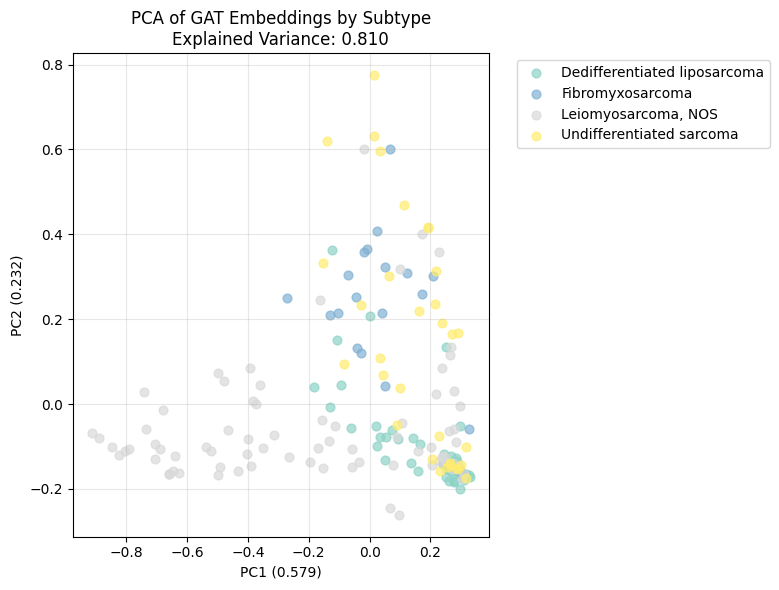

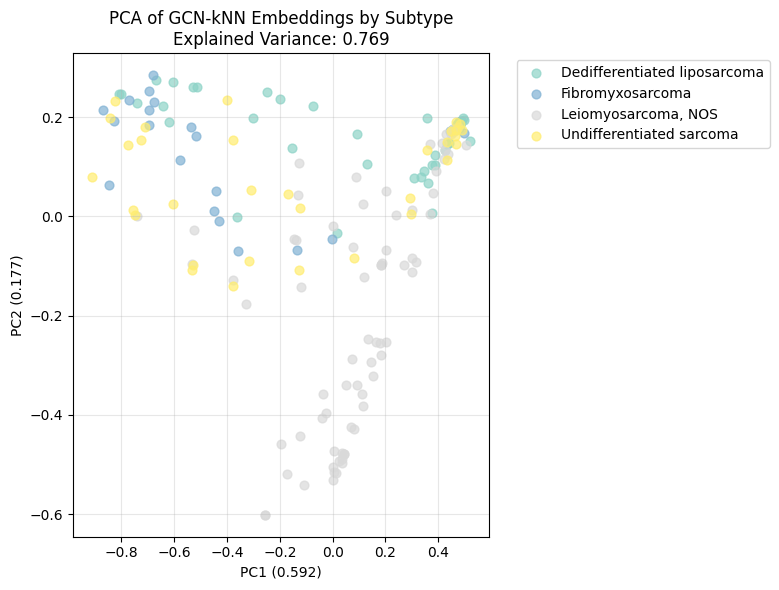

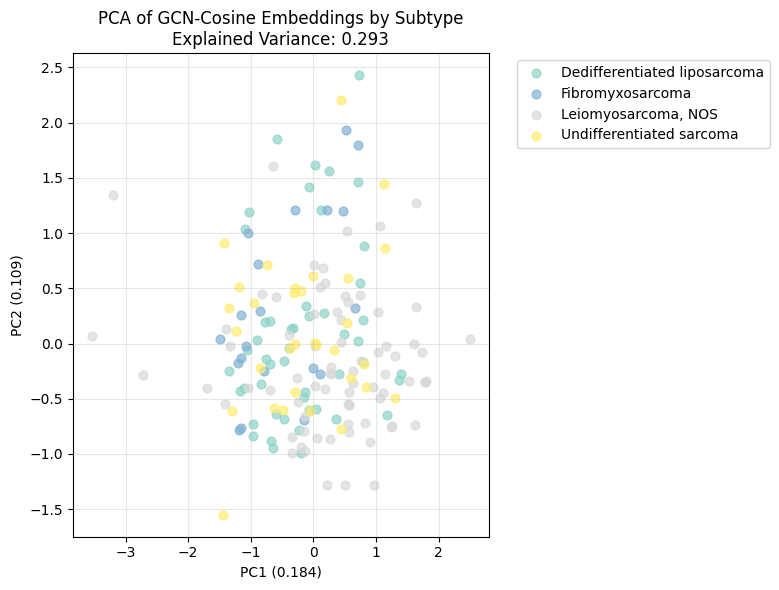

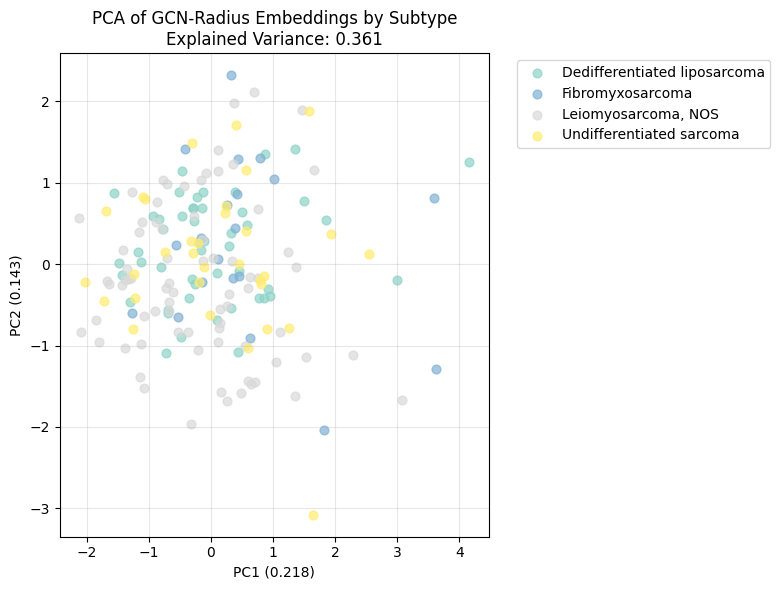

In [16]:
# PCA Visualization for GAT and GCN Embeddings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def plot_pca(embeddings, labels, title, subtype_mapping):
    pca = PCA(n_components=2, random_state=42)
    emb_2d = pca.fit_transform(embeddings)
    unique_subtypes = np.unique(labels)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_subtypes)))
    class_names = [list(subtype_mapping.keys())[list(subtype_mapping.values()).index(i)] for i in unique_subtypes]
    plt.figure(figsize=(8, 6))
    for i, subtype in enumerate(unique_subtypes):
        mask = labels == subtype
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c=[colors[i]], label=class_names[i], alpha=0.7, s=40)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
    plt.title(title + f'\nExplained Variance: {pca.explained_variance_ratio_.sum():.3f}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# GAT embeddings
plot_pca(gat_embeddings.values, subtype_encoded.values, 'PCA of GAT Embeddings by Subtype', subtype_mapping)

# GCN embeddings (kNN, Cosine, Radius)
for graph_name in ['kNN', 'Cosine', 'Radius']:
    gcn_emb = gcn_results[graph_name]['embeddings']
    plot_pca(gcn_emb.values, subtype_encoded.values, f'PCA of GCN-{graph_name} Embeddings by Subtype', subtype_mapping)

In [29]:
# Install mofapy2 if not already installed
from mofapy2.run.entry_point import entry_point

# Prepare omics data for MOFA (features x samples for each view)
# Each omics view must be features x samples, and all must have the same number of columns (samples)
omics_views = [
    expression_data_scaled,
    methylation_scaled,
    copy_number_scaled,
    protein_scaled
    # Add more omics if available
 ]

# Remove non-numeric columns if present (should not be needed if already processed)
omics_views = [df.select_dtypes(include=[float, int]) for df in omics_views]

# Ensure all omics have the same columns (samples, order matters)
common_samples = list(expression_data_scaled.columns)
omics_views = [df[common_samples] for df in omics_views]

# Convert to numpy arrays (features x samples)
data_list = [view.values for view in omics_views]
data_list = [data_list]  # Wrap in a list for 1 group with 4 views

# Initialize MOFA
ent = entry_point()
ent.set_data_options(scale_groups=False, scale_views=False)
ent.set_data_matrix(data_list)
ent.set_model_options(factors=20, spikeslab_factors=True, ard_factors=True, ard_weights=True)
ent.set_train_options(iter=50, convergence_mode="medium", seed=42, verbose=True)
ent.build()
ent.run()
model = ent.model

# Extract factors (Z) and weights (W)
factors = model.nodes["Z"].getExpectation() #list(one per group):each is samples x factors
weights = model.nodes["W"].getExpectation() #list(one per view):each is features x factors
print("MOFA factors shape (samples x factors):", factors[0].shape)
print("MOFA weights shape (features x factors):", weights[0].shape)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group